In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('../src'))
import numpy as np
import hockey.hockey_env as h_env
import gymnasium as gym
from importlib import reload
import time
from dotenv import load_dotenv
load_dotenv('../.env')

from custom_sb3.replay_buffer import EREBuffer
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
env = h_env.HockeyEnv()

In [67]:
import pytest
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3.common.vec_env import VecNormalize

# Utility function to create a dummy environment
def create_dummy_env():
    return h_env.HockeyEnv()

# Utility function to create a buffer with dummy spaces
def create_buffer(obs_space, action_space, buffer_size=1000, use_per=False, eta0=0.996, etaT=1, total_timesteps=1_000_000, cmin=500, alpha=0.6):
    # obs_space = spaces.Box(low=-1, high=1, shape=(4,))
    # action_space = spaces.Box(low=-1, high=1, shape=(2,))
    return EREBuffer(buffer_size, obs_space, action_space, "cpu", use_per=use_per, 
                     eta0=eta0, etaT=etaT, total_timesteps=total_timesteps, cmin=cmin, alpha=alpha)



Using EREBuffer with: use_per=False, alpha=0.6, eta0=0.996, etaT=1, cmin=500, total_timesteps=1000000
self.n_envs 1


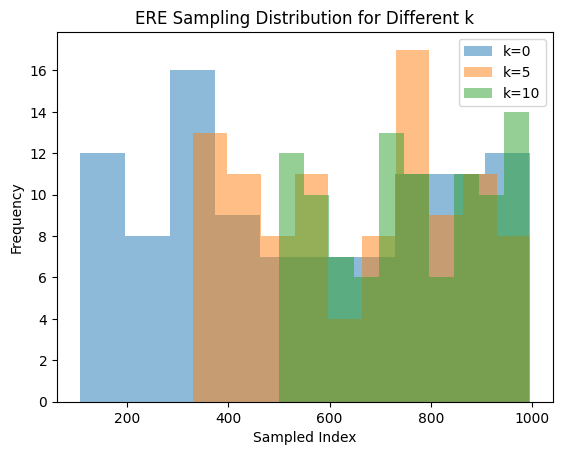

In [125]:
# Does not cover wrap-around case! Only for visualization purposes
batch_size=100
K=10
buffer_size=1000
"""Verify that ERE samples more recent experiences as k increases."""
env = h_env.HockeyEnv()
buffer = EREBuffer(buffer_size=buffer_size, observation_space=env.observation_space, action_space=env.action_space, device='cpu', cmin=500, eta0=0.996, etaT=1, total_timesteps=1_000_000)
for i in range(buffer_size):
    buffer.add(np.array([0]*env.observation_space.shape[0]), np.array([0]*env.observation_space.shape[0]), np.array([0]*env.action_space.shape[0]), np.array([0]), np.array([False]), [{}])

k_values = np.sort(np.random.choice(K,3,replace=False))
sampled_indices = [buffer.sample(batch_size, k=k, K=K, current_timestep=0)[1] for k in k_values] # leaving current_timestep at 0 fixes eta
plt.hist(sampled_indices[0], alpha=0.5, label="k=0")
plt.hist(sampled_indices[1], alpha=0.5, label="k=5")
plt.hist(sampled_indices[2], alpha=0.5, label="k=10")
plt.legend()
plt.title("ERE Sampling Distribution for Different k")
plt.xlabel("Sampled Index")
plt.ylabel("Frequency")
plt.show()
assert np.mean(sampled_indices[2]) > np.mean(sampled_indices[0])  # Later k should sample more recent indices


&rarr; The larger k, the stronger the recency bias. k=0 corresponds to uniform sampling

Using EREBuffer with: use_per=True, alpha=0.6, eta0=0.996, etaT=1, cmin=500, total_timesteps=1000000
self.n_envs 1


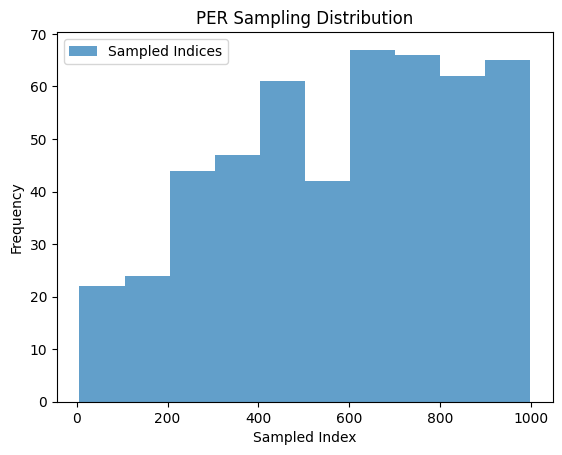

In [ ]:
buffer_size=1000
"""Verify that PER samples high-priority experiences more often."""
env = h_env.HockeyEnv()
buffer = EREBuffer(buffer_size=buffer_size, device='cpu', cmin=500, eta0=0.996, etaT=1, total_timesteps=1_000_000, use_per=True, alpha=0.6, observation_space=env.observation_space, action_space=env.action_space)
for i in range(buffer_size):
    buffer.add(np.array([i]*env.observation_space.shape[0]), np.array([i+1]*env.observation_space.shape[0]), np.array([0]*env.action_space.shape[0]), np.array([0]), np.array([False]), [{}])
    buffer.priorities[i % buffer_size, 0] = (i + 1) ** buffer.alpha  # Set priorities increasing

sampled_indices = buffer.sample(500, current_timestep=0, k=0, K=1)[1] # set k=0 for c_k=buffer_size
plt.hist(sampled_indices, bins=10, alpha=0.7, label="Sampled Indices")
plt.title("PER Sampling Distribution")
plt.xlabel("Sampled Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

assert np.mean(sampled_indices) > 500 and np.median(sampled_indices) > 500 # More recent indices should be sampled more due to higher priority

Using EREBuffer with: use_per=True, alpha=0.6, eta0=0.996, etaT=1, cmin=500, total_timesteps=1000000
self.n_envs 1


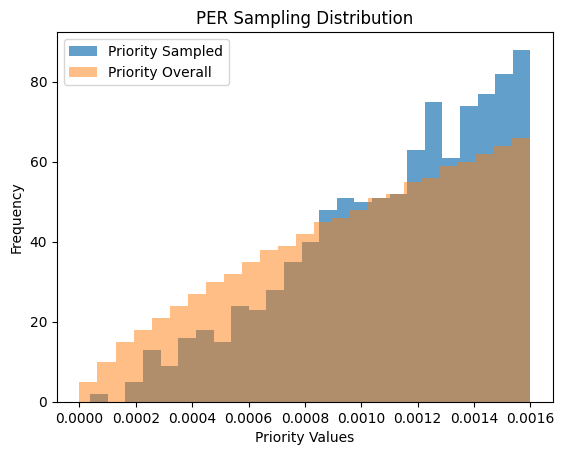

In [ ]:
"""Verify that PER samples high-priority experiences more often with wrap-around"""
buffer_size=1000
total_timesteps = 5*buffer_size # wrap-around case
env = h_env.HockeyEnv()
buffer = EREBuffer(buffer_size=buffer_size, device='cpu', cmin=500, eta0=0.996, etaT=1, total_timesteps=1_000_000, use_per=True, alpha=0.6, observation_space=env.observation_space, action_space=env.action_space)

for i in range(total_timesteps):
    buffer.add(np.array([i]*env.observation_space.shape[0]), np.array([i+1]*env.observation_space.shape[0]), np.array([0]*env.action_space.shape[0]), np.array([0]), np.array([False]), [{}])
    buffer.priorities[i % buffer_size, 0] = (i % buffer_size) ** buffer.alpha  # Set priorities increasing

buffer.priorities[:, 0] = buffer.priorities[:, 0] / np.sum(buffer.priorities[:, 0])  # Normalize

sampled_indices = buffer.sample(1000, current_timestep=0, k=0, K=1)[1]

# get the priority values of the sampled indices
priority_values = buffer.priorities[sampled_indices, 0]
plt.hist(priority_values, bins=25, alpha=0.7, label="Priority Sampled")
plt.hist(buffer.priorities[:, 0], bins=25, alpha=0.5, label="Priority Overall")
plt.title("PER Sampling Distribution")
plt.xlabel("Priority Values")
plt.ylabel("Frequency")
plt.legend()
plt.show()

--> Values with higher priority values are sampled

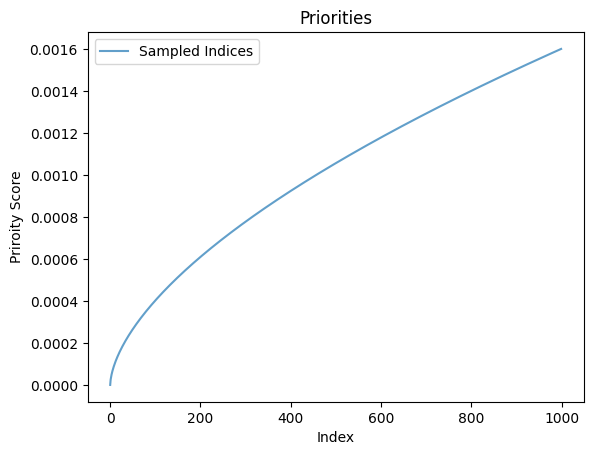

In [331]:
plt.plot(buffer.priorities[:,0], alpha=0.7, label="Sampled Indices")
plt.title("Priorities")
plt.xlabel("Index")
plt.ylabel("Priroity Score")
plt.legend()
plt.show()

In [ ]:
import numpy as np



Using EREBuffer with: use_per=True, alpha=0.6, eta0=0.996, etaT=1, cmin=500, total_timesteps=1000000
self.n_envs 1
